## Define graph class

In [1]:
%%tensorflow graph


import google.cloud.ml as cloudml
import google.cloud.ml.models as models
import json
import math
import tensorflow as tf
from tensorflow.python.ops import embedding_ops as embeddings

    
class ImdbSentiment(models.Classification):
  def __init__(self):
    super(ImdbSentiment, self).__init__()
    
  def create_graph(self):
    with tf.Graph().as_default() as g:
      text = self._create_inputs()
      hidden_layer = self._create_hidden_layer(text['ids'], text['values'])
      logits = self._create_logits_layer(hidden_layer)
      self._create_outputs(logits)
      self._create_training(logits)
      self._create_initialization()
    return g
  
  def _create_inputs(self):
    with tf.name_scope('inputs'):
      self.examples = tf.placeholder(tf.string, name = 'examples')
      parsed_examples = self.parse_features(self.examples)
      self.targets = parsed_examples['target']
      # Our input data doesn't have Ids.
      # Assign empty strings to the ids tensor, in the same shape as the targets.
      self.keys = tf.fill(tf.shape(self.targets), tf.constant('', dtype=tf.string), name='keys')
      return parsed_examples['text']
    
  def _create_hidden_layer(self, ids, counts):
    input_size = self.metadata.features['text']['size']
    output_size = self.hyperparams.hidden_layer_size
    with tf.name_scope('hidden_layer'):
      initial_weights = tf.truncated_normal([input_size, output_size],
                                            stddev=1.0 / math.sqrt(input_size))
      weights = tf.Variable(initial_weights, name='weights')
      initial_biases = tf.zeros([output_size])
      biases = tf.Variable(initial_biases, name='biases')
      xw = embeddings.embedding_lookup_sparse(weights, ids, counts,
                                              combiner='sum')
      xwb = tf.nn.bias_add(xw, biases)
      return tf.nn.relu(xwb)
    
  def _create_logits_layer(self, hidden_layer):
    input_size = self.hyperparams.hidden_layer_size
    output_size = self.metadata.labels
    with tf.name_scope('logits_layer'):
      initial_weights = tf.truncated_normal([input_size, output_size],
                                            stddev=1.0 / math.sqrt(input_size))
      weights = tf.Variable(initial_weights, name='weights')
      initial_biases = tf.zeros([output_size])
      biases = tf.Variable(initial_biases, name='biases')
      return tf.nn.bias_add(tf.matmul(hidden_layer, weights), biases)
    
  def _create_outputs(self, logits):
    with tf.name_scope('outputs'):
      self.scores = tf.nn.softmax(logits, name='scores')
      # The tensor in self.predictions will be compared to self.targets
      # by the cloud service during evaluation.
      self.predictions = tf.arg_max(logits, 1, name='prediction')
      
  def _create_training(self, logits):
    with tf.name_scope('train'):
      with tf.name_scope('target'):
        tensor = tf.convert_to_tensor(self.targets)
        batch_size = tf.shape(tensor)[0]
        hot_rows = tf.cast(tf.expand_dims(
            tf.range(0, batch_size), 1), tensor.dtype)
        hot_indices = tf.concat(concat_dim = 1, values = [ hot_rows, tensor ])
        shape = tf.cast(tf.pack([batch_size, self.metadata.labels]), tensor.dtype)
        encoded_targets = tf.sparse_to_dense(
            hot_indices,
            shape,
            sparse_values = tf.constant(1, dtype = tf.float32),
            default_value = tf.constant(0, dtype = tf.float32))
      entropy = tf.nn.softmax_cross_entropy_with_logits(logits,
                                                        encoded_targets)
      self.loss = tf.reduce_mean(entropy, name = 'loss')
      self.global_step = tf.Variable(0, name='global_step', trainable=False)
      optimizer = tf.train.AdagradOptimizer(self.hyperparams.learning_rate)
      self.train = optimizer.minimize(self.loss, self.global_step)
      
  def _create_initialization(self):
    self.initialize = tf.initialize_all_variables()

## Define training dataset (Please copy to local from gs://cloud-ml-users-data/qimingj/imdb)

In [2]:
%%ml dataset -n imdb_data_local
train: /content/imdb/preprocessed_train
test: /content/imdb/preprocessed_train
metadata: /content/imdb/metadata.yaml

## Training

In [10]:
%%ml train -m imdb.v1 -d imdb_data_local --overwrite
batch_size: 10
learning_rate: 0.1
hidden_layer_size: 10
steps: 1000

## Watch live events

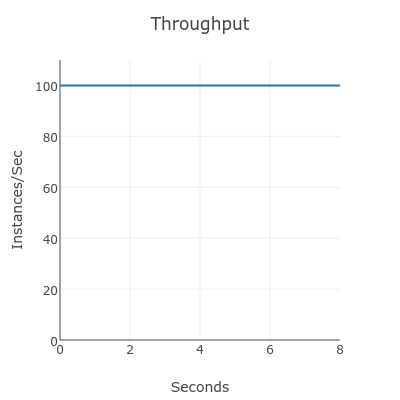

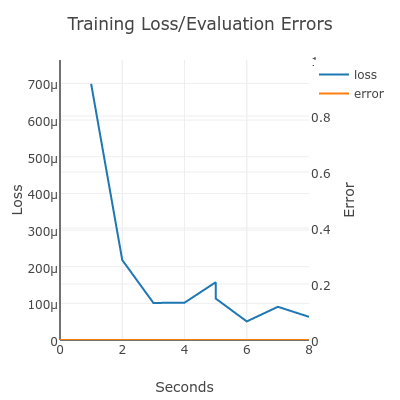

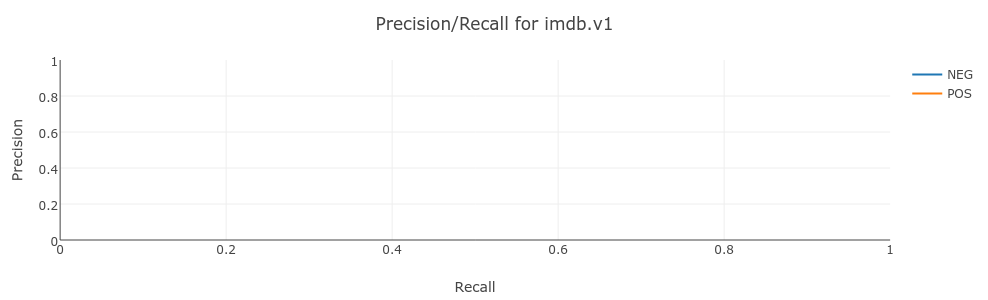

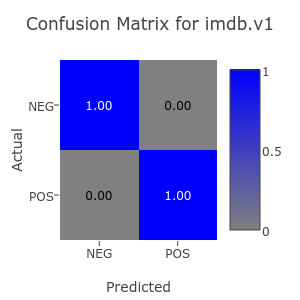

In [13]:
%%ml analyze -m imdb.v1

## Running it in cloud
You can train the model in cloud too especially if your model is deeper and more complicated, and your data is much larger. You just need to make 2 changes: Change your data from local path to Cloud Storage path, and add "--cloud" on "%%ml train" and "%%ml analyze" commands